In [22]:
import os
import sys 
sys.path.append('../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import RobustScaler
from monai.networks.nets import UNet
from awloss import AWLoss

%autoreload 2
from networks import *
from train_utils import *
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import plotly.express as px
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utilities

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def robust_scalar(x):
    shape = x.shape
    rs = RobustScaler()
    x = rs.fit_transform(x.flatten(start_dim=1))
    return torch.tensor(x.reshape(shape), dtype=torch.float32)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x



# MRI Dataset 

In [49]:
# Dataset
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI_volumes/")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 64, 64, 64)),
                    Lambda(lambda x: clip_outliers(x)),
                    Lambda(lambda x: scale2range(x, [0., 1.])),
                    ])
ds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,2),
                                        maxsamples=16)
print(ds, "\n")

{'name': 'UndersampledUltrasoundDataset3D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI_volumes', 'maxsamples': 16, 'transform': Compose(
    Lambda()
    Lambda()
    Lambda()
), 'undersample_width': (1, 1, 2), 'mode': 'mri', 'fill': 0.0, 'len': 16} 



## Data split

In [50]:
valid_ratio = 0.2
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
train_idxs, valid_idxs = [0], [0]

trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

1 1


## Dataloader

In [51]:
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

valid_loader = DataLoader(validds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


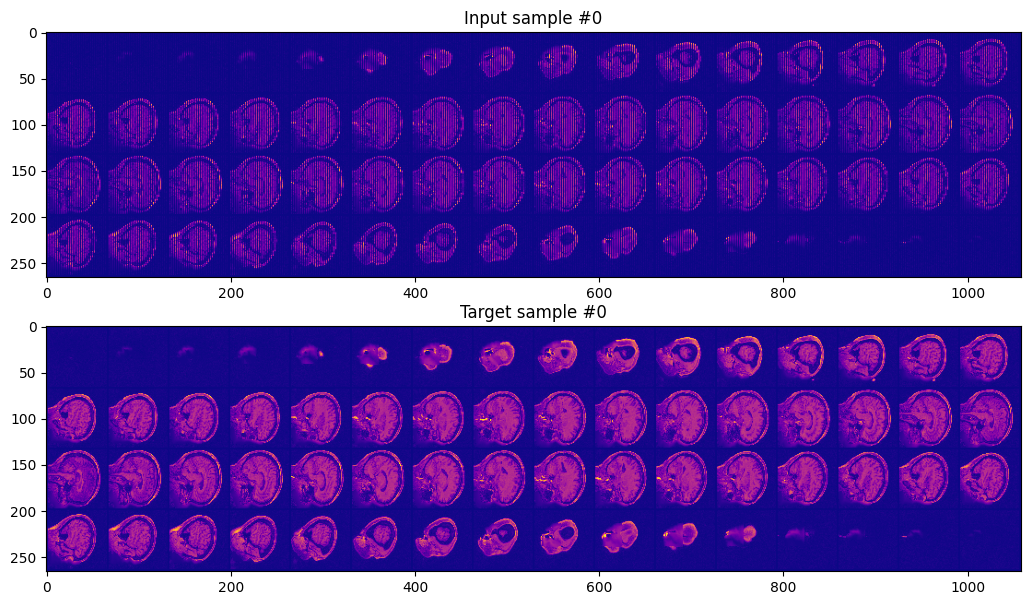

{'max': tensor(1.),
 'min': tensor(0.),
 'mean': tensor(0.0684),
 'std': tensor(0.1447),
 'shape': torch.Size([64, 64, 64])}

In [52]:
# Sample for visualisation
x_sample, y_sample = trainds[0]
print(x_sample.shape, y_sample.shape)

x_sample_grid = make_grid(x_sample.unsqueeze(1), nrow=16)[0]
y_sample_grid = make_grid(y_sample.unsqueeze(1), nrow=16)[0]

fig, axs = plt.subplots(2,1, figsize=(15,7))
axs[0].imshow(x_sample_grid, cmap="plasma")
axs[0].set_title("Input sample #0")
axs[1].imshow(y_sample_grid, cmap="plasma")
axs[1].set_title("Target sample #0")
plt.show()

trainds.dataset.info(nsamples=1)

## Model 

In [53]:
def make_model(channels=64):
    return UNet(
    spatial_dims=2,
    in_channels=channels,
    out_channels=channels,
    channels=(16, 32, 64, 128, 256),
    strides=tuple([2 for i in range(channels)]), 
    num_res_units=2,
    act="mish",
).to(device)

print(make_model())

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (

/home/dp4018/.local/lib/python3.10/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Training Setup

In [98]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150,
                log_frequency=10, sample_input=None, sample_target=None, device="cpu", scheduler=None):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses = [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train and validate epoch
            train_loss = train(model, train_loader, optimizer, loss, scheduler, device)
            all_train_losses.append(train_loss.item())
            if valid_loader:
                valid_loss = validate(model, valid_loader, loss, device)
                all_valid_losses.append(valid_loss.item())
            bar.update(epoch)
        
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item()}
            if valid_loader:
                log.update({"valid_loss": valid_loss.item()})
                
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                if sample_input is not None:
                    model.eval()
                    recon = torch.sigmoid(model(sample_input.unsqueeze(0).to(device)))[0]

                    input_sample_grid = make_grid(sample_input.cpu().unsqueeze(1), nrow=16)[0]
                    recon_sample_grid = make_grid(recon.detach().cpu().unsqueeze(1), nrow=16)[0]

                    fig, axs = plt.subplots(3,1, figsize=(25,10))
                    axs[0].imshow(input_sample_grid, cmap="plasma")
                    axs[0].set_title("Input sample #0")
                    axs[1].imshow(recon_sample_grid, cmap="plasma")
                    axs[1].set_title("Recon sample #0")


                    if sample_target is not None:
                        target_sample_grid = make_grid(sample_target.cpu().unsqueeze(1), nrow=16)[0]
                        axs[2].imshow(target_sample_grid, cmap="plasma")
                        axs[2].set_title("Target sample #0")
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        try:
                            v, T = loss.filters[0], loss.T
                        except:
                            v, T = torch.tensor([0.]), torch.tensor([0.])
                    plt.show()

                losses_fig = plot_losses(losses={"train": all_train_losses, "valid":all_valid_losses},
                            filters={"Weiner Filter": v.flatten().cpu().detach().numpy(), "Penalty": T.flatten().cpu().detach().numpy()})

In [99]:
# Set training static parameters and hyperparameters
nepochs=300                          
learning_rate=1e-3
batch_size=4                                        
device=set_device("cuda", 0)

Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


/home/dp4018/.local/lib/python3.10/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")




Training started ...


  0% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_loss': 28.70915412902832, 'valid_loss': 33.58457946777344}


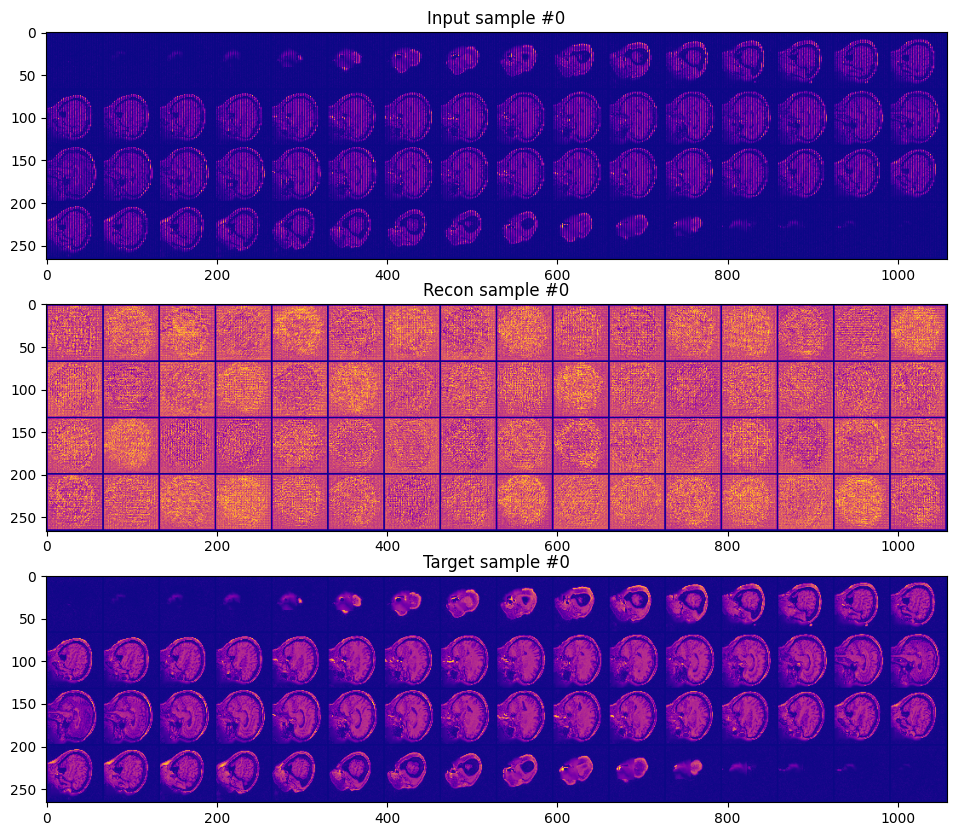

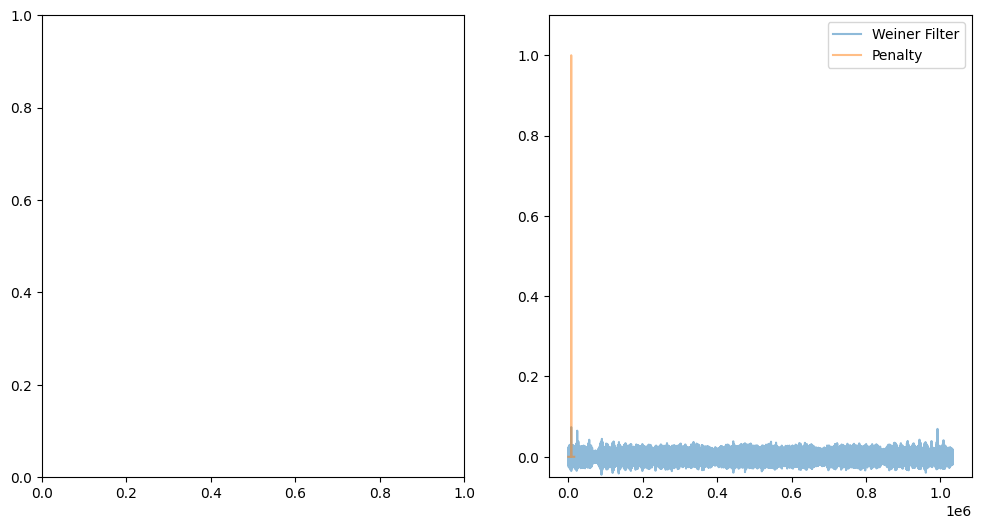

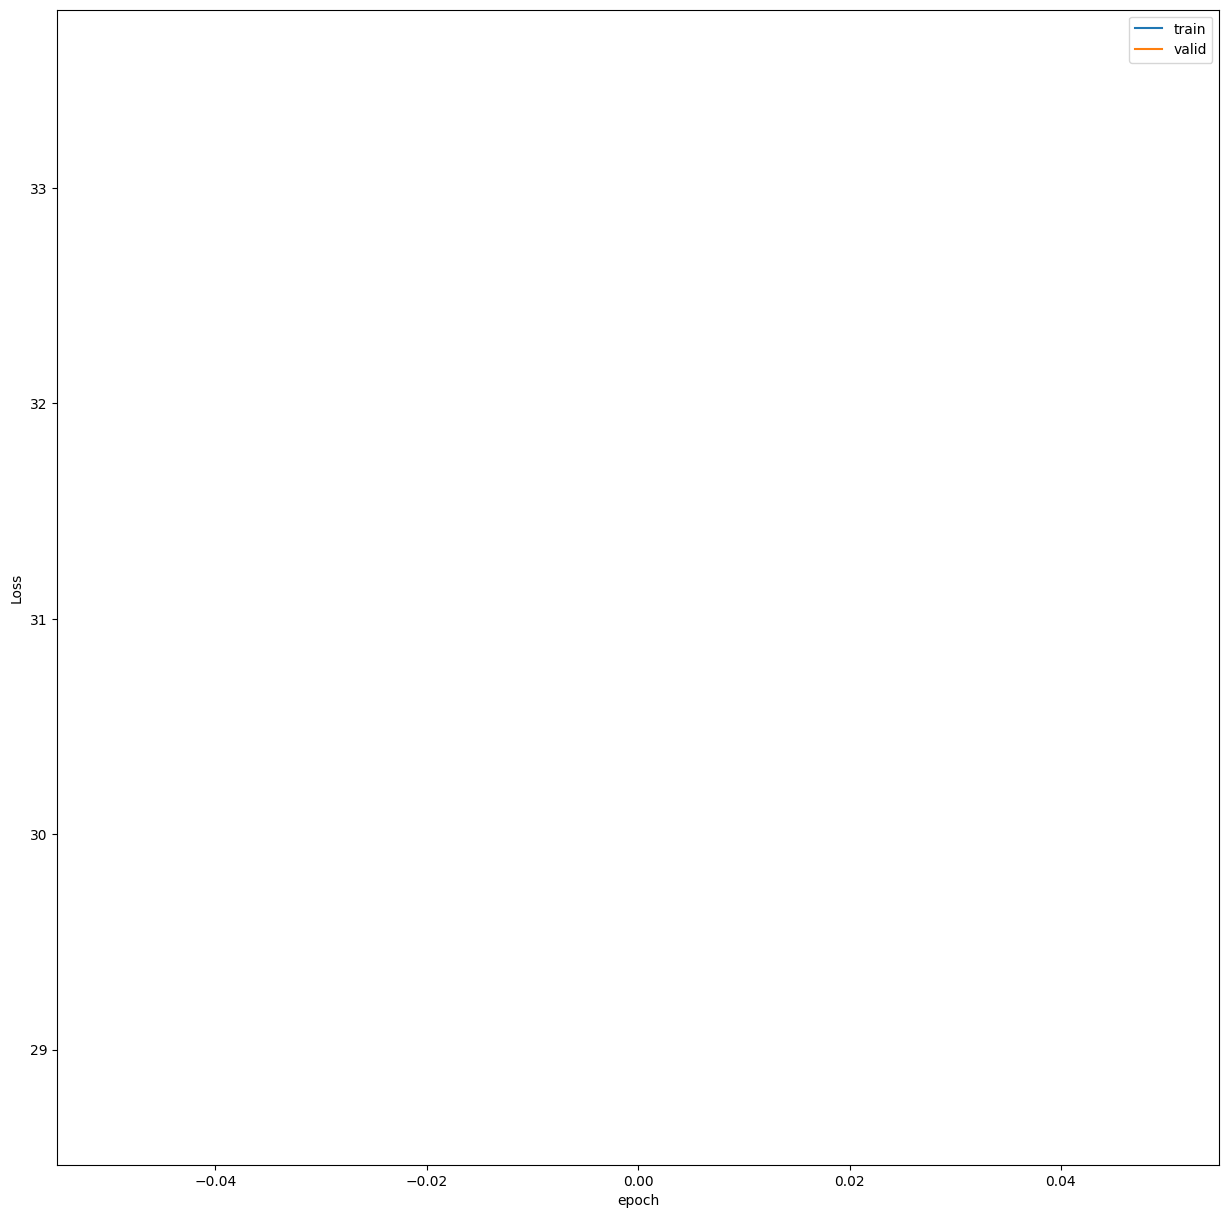

  0% (1 of 300) |                        | Elapsed Time: 0:00:02 ETA:   0:11:38
  0% (2 of 300) |                        | Elapsed Time: 0:00:03 ETA:   0:08:43
  1% (3 of 300) |                        | Elapsed Time: 0:00:04 ETA:   0:05:48
  1% (4 of 300) |                        | Elapsed Time: 0:00:05 ETA:   0:05:47
  1% (5 of 300) |                        | Elapsed Time: 0:00:07 ETA:   0:05:45
  2% (6 of 300) |                        | Elapsed Time: 0:00:08 ETA:   0:05:44
  2% (7 of 300) |                        | Elapsed Time: 0:00:09 ETA:   0:05:45
  2% (8 of 300) |                        | Elapsed Time: 0:00:10 ETA:   0:05:44
  3% (9 of 300) |                        | Elapsed Time: 0:00:11 ETA:   0:05:42
  3% (10 of 300) |                       | Elapsed Time: 0:00:12 ETA:   0:05:40
  3% (11 of 300) |                       | Elapsed Time: 0:00:14 ETA:   0:05:39
  4% (12 of 300) |                       | Elapsed Time: 0:00:15 ETA:   0:05:38
  4% (13 of 300) |                      


 {'epoch': 50, 'train_loss': 0.7671889066696167, 'valid_loss': 0.8374592065811157}


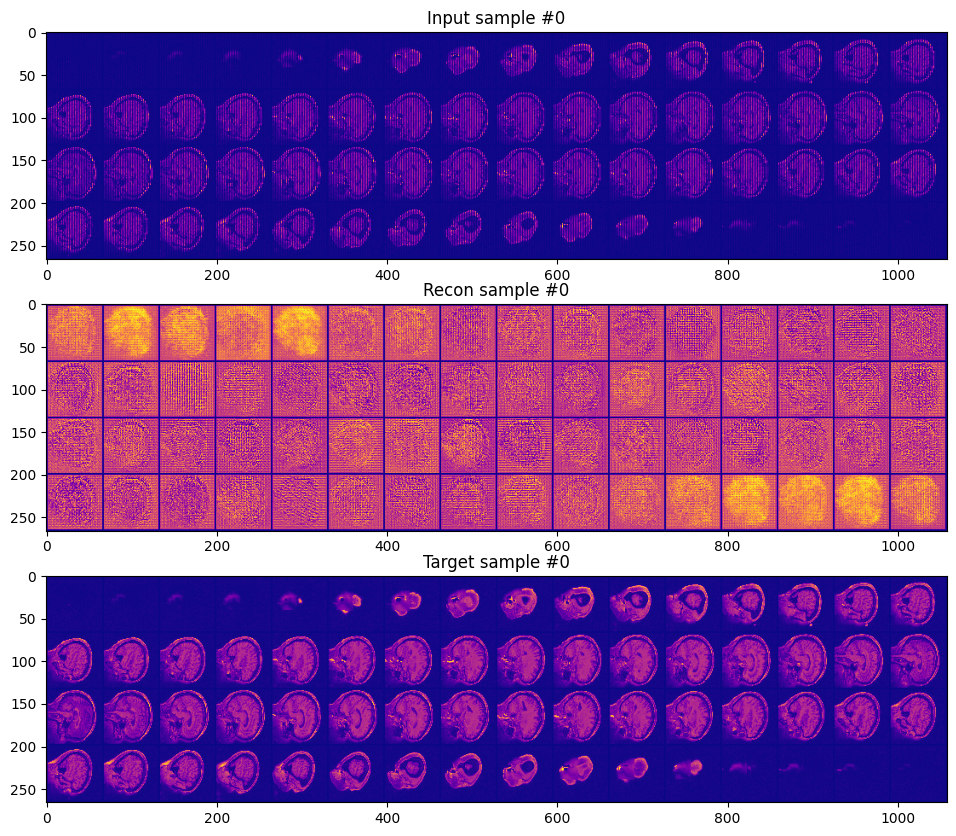

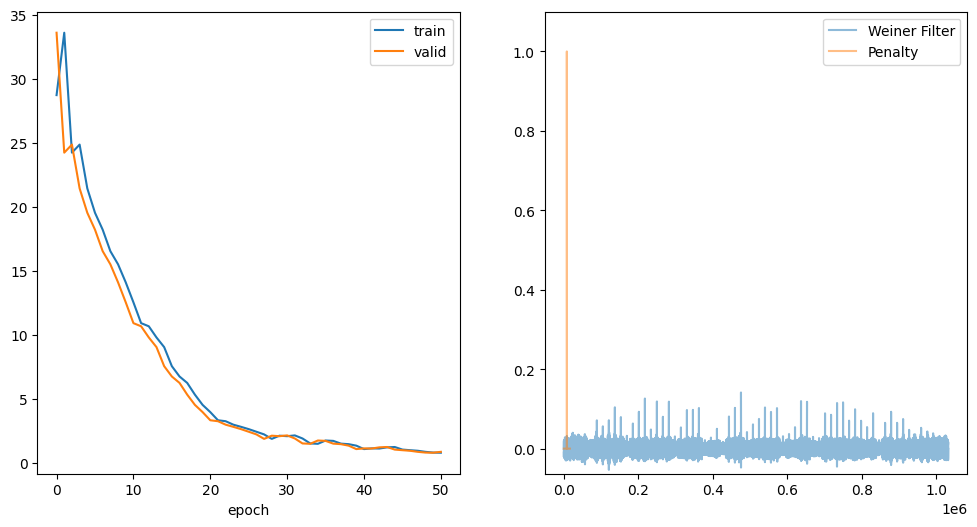

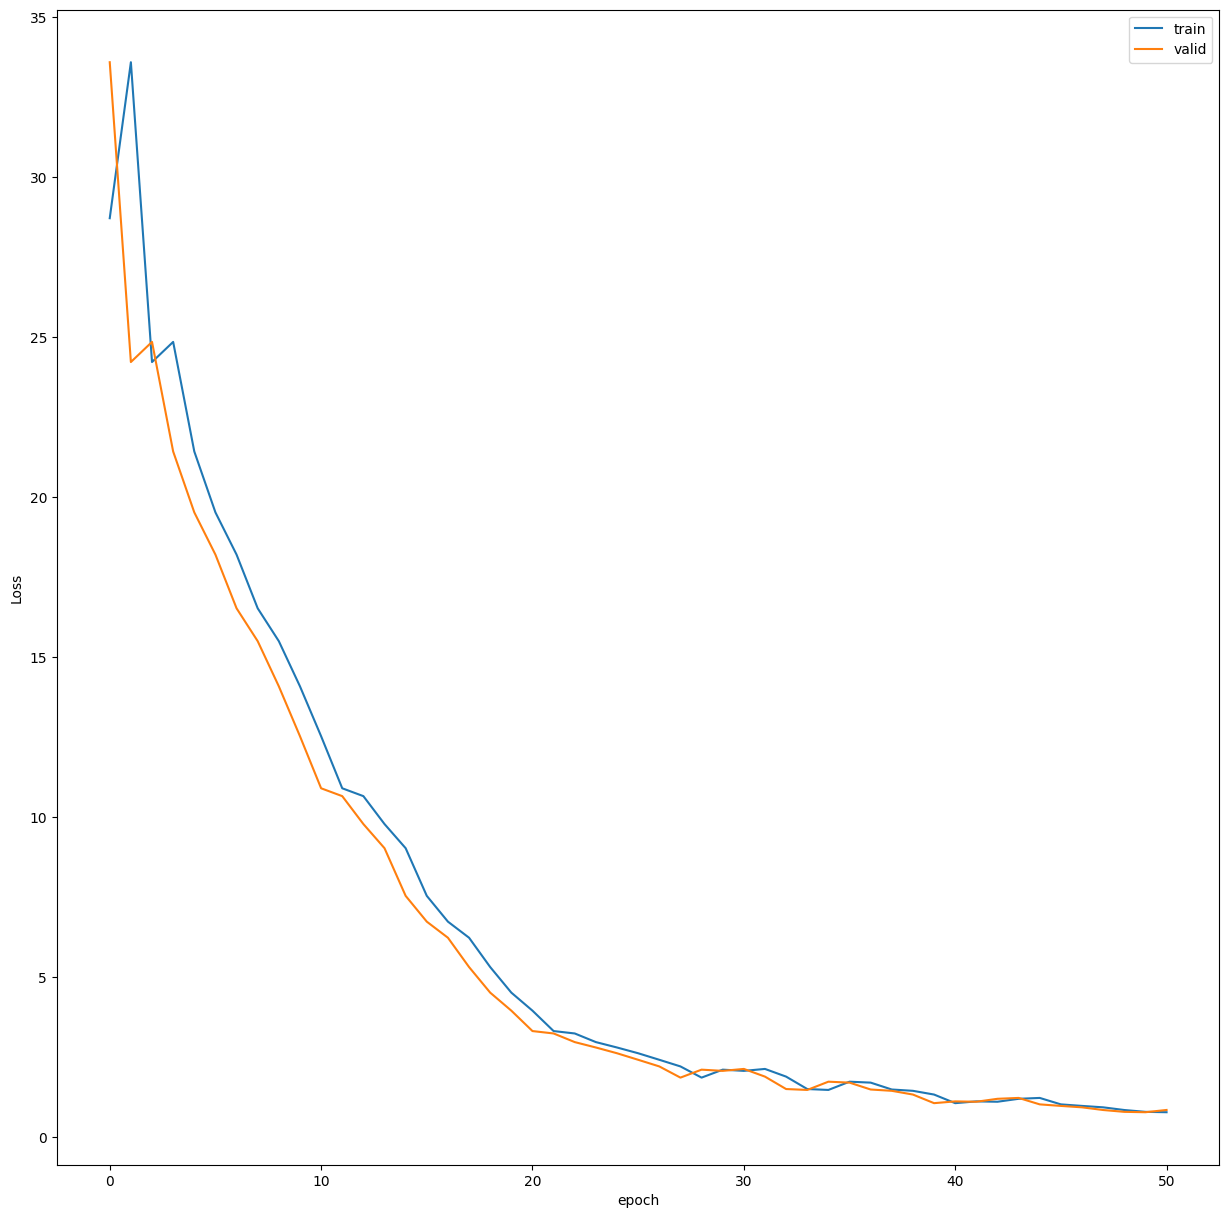

 17% (51 of 300) |###                    | Elapsed Time: 0:01:02 ETA:   0:09:54
 17% (52 of 300) |###                    | Elapsed Time: 0:01:03 ETA:   0:07:21
 17% (53 of 300) |####                   | Elapsed Time: 0:01:04 ETA:   0:04:49
 18% (54 of 300) |####                   | Elapsed Time: 0:01:05 ETA:   0:04:48
 18% (55 of 300) |####                   | Elapsed Time: 0:01:07 ETA:   0:04:47
 18% (56 of 300) |####                   | Elapsed Time: 0:01:08 ETA:   0:04:46
 19% (57 of 300) |####                   | Elapsed Time: 0:01:09 ETA:   0:04:45
 19% (58 of 300) |####                   | Elapsed Time: 0:01:10 ETA:   0:04:44
 19% (59 of 300) |####                   | Elapsed Time: 0:01:11 ETA:   0:04:42
 20% (60 of 300) |####                   | Elapsed Time: 0:01:13 ETA:   0:04:42
 20% (61 of 300) |####                   | Elapsed Time: 0:01:14 ETA:   0:04:40
 20% (62 of 300) |####                   | Elapsed Time: 0:01:15 ETA:   0:04:40
 21% (63 of 300) |####                  

KeyboardInterrupt: 

In [100]:
awloss = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
model = make_model(channels=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, valid_loader, nepochs=nepochs,
            log_frequency=50, sample_input=x_sample, sample_target=y_sample, device=device)